## Import useful libraries

In [1]:
import pandas as pd
import numpy as np
import datetime
import pytz
import matplotlib.pyplot as plt

from airflow.providers.mysql.hooks.mysql import MySqlHook

## User settings

In [2]:
#list_of_price_types = ['bid', 'mid', 'ask']
#instrument_name = 'EUR/USD'
#interval_name = 'Day'

database_name = 'django'

## Connect to database

In [3]:
mysql_hook = MySqlHook(mysql_conn_id = database_name)

## Define a function to pull candlestick data

This only works for a single (price type, instrument, interval) tuple.

In [4]:
def get_candlestick_pull_query():
    sql_query_for_candlestick_pull = """SELECT

    ts.timestamp, inst.name AS instrument_name, cs.o, cs.l, cs.h, cs.c, v.volume

    FROM

    timeseries_candlestick cs, timeseries_instrument inst,
    timeseries_interval iv, timeseries_pricetype pt,
    timeseries_volume v, timeseries_timestamp ts

    WHERE

    cs.instrument_id = inst.id
    AND cs.interval_id = iv.id
    AND cs.price_type_id = pt.id
    AND cs.volume_id = v.id
    AND cs.timestamp_id = ts.id

    AND pt.name = '%s'
    AND inst.name = '%s'
    AND iv.name = '%s'

    ORDER BY timestamp
    ;
    """

    return sql_query_for_candlestick_pull

In [5]:
class CandlestickDataFrame():

    def __init__(
        self,
        instrument_name = 'EUR/USD',
        interval_name = 'Day',
        cut_before_year = 2014,
        list_of_price_types = ['bid', 'mid', 'ask'],  # Don't change this!
        timezone_to_use = 'US/Eastern',  # Don't change this!
    ):
        
        self.list_of_price_types = list_of_price_types
        self.instrument_name = instrument_name
        self.interval_name = interval_name
        self.timezone_to_use = timezone_to_use
        self.cut_before_year = cut_before_year

    def create_initial_dataframe(self):
        
        list_of_dataframes = []

        for pt in self.list_of_price_types:
            sql_to_run = get_candlestick_pull_query() % (pt, self.instrument_name, self.interval_name)
            df_pt = mysql_hook.get_pandas_df(sql_to_run)
    
            column_name_map = {}
            for col_name in ['o', 'l', 'h', 'c', 'volume']:
                column_name_map[col_name] = pt + '_' + col_name

            df_pt.rename(columns = column_name_map, inplace = True)

            list_of_dataframes.append(df_pt)

        df = list_of_dataframes[0]
        for df_i in list_of_dataframes[1:]:
            df = pd.merge(df, df_i, how = 'left', on = ['timestamp', 'instrument_name'])

        self.df = df

    def add_date_and_time_related_features(self):
        tz = pytz.timezone(self.timezone_to_use)
        self.df['timestamp_dt_Eastern'] = [datetime.datetime.fromtimestamp(x, tz = tz) for x in self.df['timestamp']]
        self.df['weekday_Eastern'] = [x.weekday() for x in self.df['timestamp_dt_Eastern']]
        self.df['hour_Eastern'] = [x.hour for x in self.df['timestamp_dt_Eastern']]
        self.df['year_Eastern'] = [x.year for x in self.df['timestamp_dt_Eastern']]

    def filter_by_date_and_time_related_features(self):
        self.df = self.df[self.df['year_Eastern'] >= self.cut_before_year].copy()

    def conduct_volume_test(self):
        volume_test = np.min(
            np.int8(
                (self.df['ask_volume'].values == self.df['mid_volume']) &
                (self.df['mid_volume'].values == self.df['bid_volume'])
            )
        )
        
        if volume_test == 1:
            self.df['volume'] = self.df['mid_volume']
            self.df.drop(columns = [x + '_volume' for x in self.list_of_price_types], inplace = True)
            self.volume_test = True
        else:
            self.volume_test = False

    def conduct_nan_test(self):
        self.are_there_nans = (len(self.df.index) != len(self.df.dropna().index))

    # https://www.investopedia.com/terms/s/spread.asp#toc-5-forex-spreads
    def compute_spread(self):
        for item in ['o', 'l', 'h', 'c']:
            self.df['spread_' + item] = self.df['ask_' + item] - self.df['bid_' + item]

    def is_mid_really_the_mid(self):
        self.dict_max_abs_diff_in_mid_check = {}
        columns_used_here = []
        for item in ['o', 'l', 'h', 'c']:
            self.df['mid_computed_' + item] = np.round((self.df['bid_' + item] + self.df['ask_' + item]) / 2., 5)
            self.df['mid_compare_' + item] = self.df['mid_' + item] == self.df['mid_computed_' + item]
            self.df['mid_diff_' + item] = np.abs(self.df['mid_' + item] - self.df['mid_computed_' + item])
            
            self.dict_max_abs_diff_in_mid_check[item] = np.max(self.df['mid_diff_' + item])

            columns_used_here.append('mid_' + item)
            columns_used_here.append('mid_computed_' + item)
            columns_used_here.append('mid_compare_' + item)
            columns_used_here.append('mid_diff_' + item)

        self.df_mid_test = self.df[columns_used_here].copy()

        for item in ['o', 'l', 'h', 'c']:
            self.df.drop(
                columns = [
                    'mid_computed_' + item,
                    'mid_compare_' + item,
                    'mid_diff_' + item,
                ],
                inplace = True,
            )


    def compute_return_and_volatility(self):
        for pt in self.list_of_price_types:
            self.df[pt + '_return'] = self.df[pt + '_c'] - self.df[pt + '_o']
            self.df[pt + '_volatility'] = self.df[pt + '_h'] - self.df[pt + '_l']

    
    def fit(self):
        self.create_initial_dataframe()
        self.conduct_volume_test()
        self.add_date_and_time_related_features()
        self.filter_by_date_and_time_related_features()
        self.conduct_nan_test()
        self.compute_spread()
        self.is_mid_really_the_mid()
        self.compute_return_and_volatility()

In [6]:
cdf = CandlestickDataFrame()
cdf.fit()

[2025-03-30T13:23:24.318-0700] {base.py:84} INFO - Retrieving connection 'django'


/home/emily/venvs/ml/lib/python3.10/site-packages/airflow/providers/common/sql/hooks/sql.py:287 UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.

In [7]:
cdf.df

,timestamp,instrument_name,bid_o,bid_l,bid_h,bid_c,mid_o,mid_l,mid_h,mid_c,...,spread_o,spread_l,spread_h,spread_c,bid_return,bid_volatility,mid_return,mid_volatility,ask_return,ask_volatility
3852,1388613600,EUR/USD,1.37450,1.36290,1.37744,1.36708,1.37525,1.36296,1.37756,1.36722,...,0.00150,0.00012,0.00025,0.00027,-0.00742,0.01454,-0.00803,0.01460,-0.00865,0.01467
3853,1388700000,EUR/USD,1.36708,1.35818,1.36714,1.35868,1.36728,1.35825,1.36745,1.35888,...,0.00039,0.00014,0.00106,0.00041,-0.00840,0.00896,-0.00840,0.00920,-0.00838,0.00988
3854,1388959200,EUR/USD,1.35912,1.35707,1.36525,1.36272,1.35936,1.35714,1.36532,1.36292,...,0.00049,0.00013,0.00014,0.00040,0.00360,0.00818,0.00356,0.00818,0.00351,0.00819
3855,1389045600,EUR/USD,1.36273,1.35962,1.36558,1.36147,1.36293,1.35968,1.36564,1.36157,...,0.00040,0.00011,0.00013,0.00020,-0.00126,0.00596,-0.00136,0.00596,-0.00146,0.00598
3856,1389132000,EUR/USD,1.36148,1.35527,1.36346,1.35742,1.36156,1.35534,1.36352,1.35757,...,0.00017,0.00013,0.00013,0.00030,-0.00406,0.00819,-0.00399,0.00818,-0.00393,0.00819
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6764,1742763600,EUR/USD,1.08138,1.07808,1.08576,1.08004,1.08156,1.07816,1.08583,1.08012,...,0.00036,0.00015,0.00015,0.00016,-0.00134,0.00768,-0.00144,0.00767,-0.00154,0.00768
6765,1742850000,EUR/USD,1.08004,1.07763,1.08295,1.07905,1.08013,1.07770,1.08302,1.07918,...,0.00018,0.00014,0.00015,0.00025,-0.00099,0.00532,-0.00095,0.00532,-0.00092,0.00533
6766,1742936400,EUR/USD,1.07890,1.07432,1.08021,1.07518,1.07940,1.07439,1.08029,1.07528,...,0.00100,0.00014,0.00016,0.00021,-0.00372,0.00589,-0.00412,0.00590,-0.00451,0.00591
6767,1743022800,EUR/USD,1.07552,1.07322,1.08205,1.08011,1.07578,1.07330,1.08212,1.08020,...,0.00053,0.00016,0.00016,0.00019,0.00459,0.00883,0.00442,0.00882,0.00425,0.00883


In [8]:
cdf.are_there_nans

False

In [9]:
cdf.volume_test

True

In [10]:
import pprint as pp
pp.pprint(cdf.dict_max_abs_diff_in_mid_check)

{'c': 1.0000000000065512e-05,
 'h': 0.00034000000000000696,
 'l': 0.00031999999999987594,
 'o': 1.0000000000065512e-05}


In [11]:
cdf.df_mid_test

,mid_o,mid_computed_o,mid_compare_o,mid_diff_o,mid_l,mid_computed_l,mid_compare_l,mid_diff_l,mid_h,mid_computed_h,mid_compare_h,mid_diff_h,mid_c,mid_computed_c,mid_compare_c,mid_diff_c
3852,1.37525,1.37525,True,0.0,1.36296,1.36296,True,0.0,1.37756,1.37757,False,0.00001,1.36722,1.36722,True,0.0
3853,1.36728,1.36728,True,0.0,1.35825,1.35825,True,0.0,1.36745,1.36767,False,0.00022,1.35888,1.35888,True,0.0
3854,1.35936,1.35936,True,0.0,1.35714,1.35714,True,0.0,1.36532,1.36532,True,0.00000,1.36292,1.36292,True,0.0
3855,1.36293,1.36293,True,0.0,1.35968,1.35968,True,0.0,1.36564,1.36564,True,0.00000,1.36157,1.36157,True,0.0
3856,1.36156,1.36156,True,0.0,1.35534,1.35534,True,0.0,1.36352,1.36352,True,0.00000,1.35757,1.35757,True,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6764,1.08156,1.08156,True,0.0,1.07816,1.07816,True,0.0,1.08583,1.08583,True,0.00000,1.08012,1.08012,True,0.0
6765,1.08013,1.08013,True,0.0,1.07770,1.07770,True,0.0,1.08302,1.08303,False,0.00001,1.07918,1.07918,True,0.0
6766,1.07940,1.07940,True,0.0,1.07439,1.07439,True,0.0,1.08029,1.08029,True,0.00000,1.07528,1.07528,True,0.0
6767,1.07578,1.07578,True,0.0,1.07330,1.07330,True,0.0,1.08212,1.08213,False,0.00001,1.08020,1.08020,True,0.0


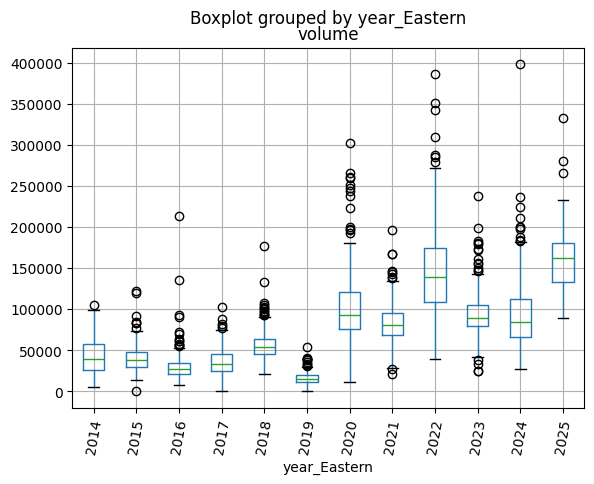

In [12]:
#(
#    cdf.df
#    .groupby('year_Eastern')
#    ['timestamp']
#    .agg('count')
#)

cdf.df.boxplot(column = 'volume', by = 'year_Eastern')
plt.xticks(rotation = 80)
plt.show()
plt.close()

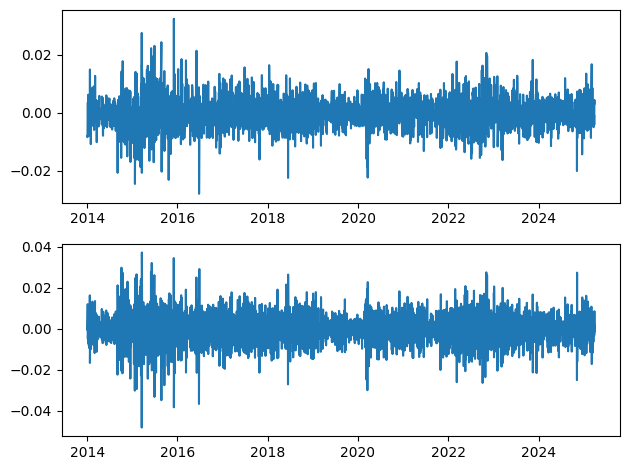

In [23]:
def plot_something_and_diff(df, column):
    plt.figure()
    
    to_plot = df[column].values
    plt.subplot(2, 1, 1)
    plt.plot(df['timestamp_dt_Eastern'].values, to_plot)
    plt.tight_layout()
    
    to_plot = df[column].values[1:] - df[column].values[0:-1]
    plt.subplot(2, 1, 2)
    plt.plot(df['timestamp_dt_Eastern'].values[1:], to_plot)
    plt.tight_layout()
    
    plt.show()
    plt.close()

plot_something_and_diff(cdf.df, 'mid_return')

In [32]:
list_of_dates = [x.date() for x in cdf.df['timestamp_dt_Eastern']]

df_to_fb_prophet = pd.DataFrame({'ds' : list_of_dates, 'y' : cdf.df['mid_return']})
df_to_fb_prophet

,ds,y
3852,2014-01-01,-0.00803
3853,2014-01-02,-0.00840
3854,2014-01-05,0.00356
3855,2014-01-06,-0.00136
3856,2014-01-07,-0.00399
...,...,...
6764,2025-03-23,-0.00144
6765,2025-03-24,-0.00095
6766,2025-03-25,-0.00412
6767,2025-03-26,0.00442


In [36]:
from prophet import Prophet
m = Prophet()
m.fit(df_to_fb_prophet)

future = m.make_future_dataframe(periods = 1)
forecast = m.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']]

[2025-03-30T13:38:52.363-0700] {forecaster.py:961} INFO - Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
[2025-03-30T13:38:52.381-0700] {filesystem.py:118} DEBUG - input tempfile: /tmp/tmpviln2_ue/6irq8v1x.json
[2025-03-30T13:38:52.497-0700] {filesystem.py:118} DEBUG - input tempfile: /tmp/tmpviln2_ue/tulborba.json
[2025-03-30T13:38:52.499-0700] {model.py:2042} DEBUG - idx 0
[2025-03-30T13:38:52.500-0700] {model.py:2043} DEBUG - running CmdStan, num_threads: None
[2025-03-30T13:38:52.500-0700] {model.py:2055} DEBUG - CmdStan args: ['/home/emily/venvs/ml/lib/python3.10/site-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=53105', 'data', 'file=/tmp/tmpviln2_ue/6irq8v1x.json', 'init=/tmp/tmpviln2_ue/tulborba.json', 'output', 'file=/tmp/tmpviln2_ue/prophet_modeluxrc2rrv/prophet_model-20250330133852.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']


13:38:52 - cmdstanpy - INFO - Chain [1] start processing


[2025-03-30T13:38:52.501-0700] {model.py:2058} INFO - Chain [1] start processing


13:38:52 - cmdstanpy - INFO - Chain [1] done processing


[2025-03-30T13:38:52.635-0700] {model.py:2115} INFO - Chain [1] done processing


,ds,yhat,yhat_lower,yhat_upper
0,2014-01-01,-0.000429,-0.007219,0.006055
1,2014-01-02,-0.000714,-0.007608,0.006138
2,2014-01-05,-0.000080,-0.006551,0.006750
3,2014-01-06,-0.000613,-0.007351,0.006635
4,2014-01-07,-0.000427,-0.007116,0.006591
...,...,...,...,...
2913,2025-03-24,-0.000153,-0.006975,0.006945
2914,2025-03-25,-0.000006,-0.006904,0.007137
2915,2025-03-26,-0.000137,-0.006703,0.007358
2916,2025-03-27,-0.000452,-0.007269,0.006519


<Figure size 640x480 with 0 Axes>

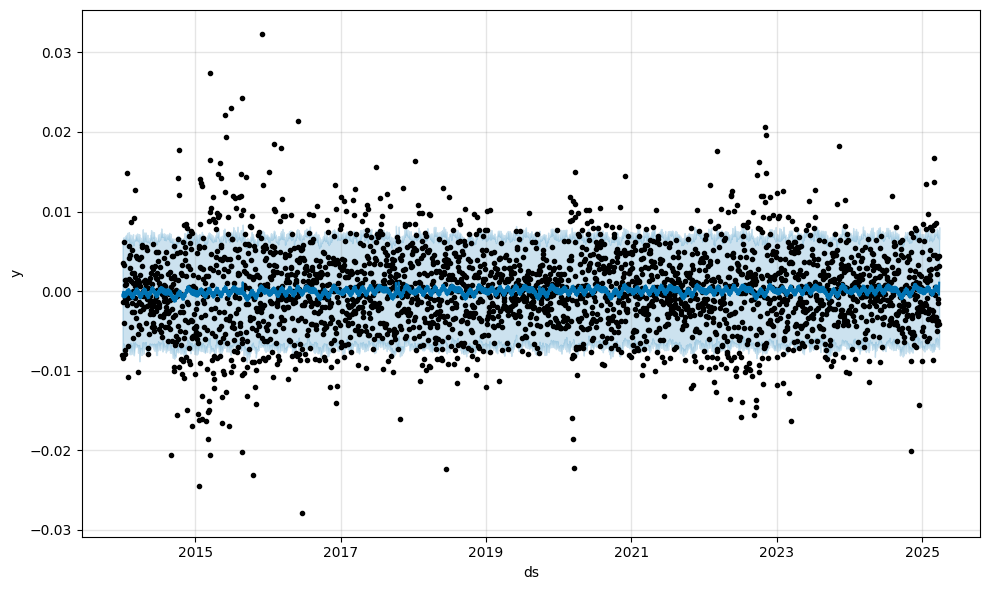

In [37]:
plt.figure()
m.plot(forecast)
plt.show()
plt.close()

In [14]:
# 
# Forex spreads are the differences between the bid price (the price at which you can sell a currency pair) and the ask price (the price at which you can buy a currency pair). This spread is essentially the cost of trading and the primary way that forex brokers make money. The size of the spread depends on market liquidity, volatility, and the specific currency pair being traded.

# Major currency pairs like EUR/USD typically have tighter spreads because of high liquidity, while exotic pairs may have wider spreads.7

#For traders, especially those engaged in short-term strategies like day trading or scalping, the spread is a crucial consideration as it directly affects the profitability of each trade. Wider spreads mean a trade needs to move further in the trader's favor just to break even. Some brokers offer fixed spreads, while others provide variable spreads that fluctuate with market conditions. 